In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import division
import math
import random

## Berlin Location Problem

We are looking for a location in Berlin. We know the following about the location:

- The candidate is likely to be close to the river Spree. The probability at any point is given by a Gaussian function of its shortest distance to the river. The function peaks at zero and has 95% of its total integral within +/-2730m

- A probability distribution centered around the Brandenburg Gate also informs us of the candidate's location. The distribution’s radial profile is log-normal with a mean of 4700m and a mode of 3877m in every direction.
    
- A satellite offers further information: with 95% probability she is located within 2400 m distance of the satellite’s path (assuming a normal probability distribution)


### Solution

As sugegsted in the additional problem description, we convert the latitude, longitude coordinates to x, y coordinates in a plane. Below are the functions that implement the conversions:

In [3]:
sw_lat, sw_lon = 52.464011, 13.274099
def to_xy(lat, lon):
    x = (lon - sw_lon) * math.cos(sw_lat * math.pi / 180) * 111.323
    y = (lat - sw_lat) * 111.323
    return x, y

def to_latlon(x, y):
    lat = y/111.323 + sw_lat
    lon = x/(math.cos(sw_lat * math.pi / 180) * 111.323) + sw_lon
    return lat, lon

The coordinates of the Spree river, the Brandenburg Gate and the sattelite path are given and converted to xy coordinates

In [4]:
spree_points = [
    (52.529198,13.274099),
    (52.531835,13.29234),
    (52.522116,13.298541),
    (52.520569,13.317349),
    (52.524877,13.322434),
    (52.522788,13.329),
    (52.517056,13.332075),
    (52.522514,13.340743),
    (52.517239,13.356665),
    (52.523063,13.372158),
    (52.519198,13.379453),
    (52.522462,13.392328),
    (52.520921,13.399703),
    (52.515333,13.406054),
    (52.514863,13.416354),
    (52.506034,13.435923),
    (52.496473,13.461587),
    (52.487641,13.483216),
    (52.488739,13.491456),
    (52.464011,13.503386),
]

spree_xy = np.array([list(to_xy(*point)) for point in spree_points])

bgate_x, bgate_y = to_xy(52.516288, 13.377689)

sat_path = np.array([
    to_xy(52.590117,13.39915),
    to_xy(52.437385,13.553989),
])

We can plot the points to see how the landscape roughly looks like. The blue line segments approximate the river, the red dot is the Brandenburg Gate, and the green line approximates the path of the sattelite.

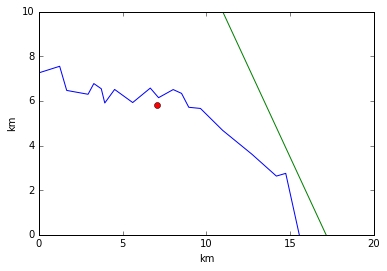

In [5]:
plot(spree_xy[:,0], spree_xy[:,1]);
plot([bgate_x], [bgate_y], 'ro-');
plot(sat_path[:,0], sat_path[:,1], 'go-');
xlim(0, 20);
ylim(0, 10);
xlabel('km');
ylabel('km');

The general approach of the proposed solution is to divide the landscape represented by the figure above into a grid of x and y coordinates, and then, for each (x,y) compute the probability that this is the correct location.

Below we define the grid. The points will be spaced roughly 100m from each other

In [6]:
N, M = 200, 100
xs = np.linspace(0, 20, N)
ys = np.linspace(0, 10, M)

Next, we define the density functions for the normal and lognormal probability distributions

In [7]:
def lognorm_pdf(x, mu, sigma):
    coef = 1.0/(x*sigma*np.sqrt(2*math.pi))
    num = np.power(np.log(x) - mu, 2)
    denom = 2*sigma**2
    return coef*np.exp(-(1/denom) * num)

def normal_pdf(x, mu, sigma):
    coef = 1.0/(sigma*np.sqrt(2*math.pi))
    return coef*np.exp(-0.5*np.power(x - mu, 2)/(2*sigma**2))

and functions to compute the distance between two points p1 and p2, and also a function which gives the shortest distance of a point to the river

In [8]:
def distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def distance_to_spree(p):
    d_min = 1000
    for i in range(1, len(spree_xy)):
        d = dist_point_to_segment(p, spree_xy[i-1], spree_xy[i])
        if d < d_min:
            d_min = d
    return d_min

#### Distance to Brandenburg Gate

The distance to the Brandenburg gate follows a lognormal distribution with mean 4.7km and mode 3.877km. From here we can compute the standard deviation sigma:

In [9]:
mu = 4.7
sigma = math.sqrt(mu - math.log(3.877))

Now, for each point in the grid, we compute its distance to the gate and evaluate the lognormal probability density function at the computed distance.

In [10]:
d_gate = np.zeros((M, N))
for i in range(N):
    for j in range(M):
        d = distance((xs[i], ys[j]), (bgate_x, bgate_y))
        d_gate[j, i] = lognorm_pdf(d, mu, sigma)


#### Distance to the River

The distance to the river follows a normal distribution centered at 0 and 95% of the probability is within 2.73km. We know that approximately 95% of the probability of a normal distribution is contained within two standard deviations, so we can deduce that the standard deviation of this distribution is 2.73/2, and the mean is of course 0.

Again, for every point in the grid, we compute the shortest distance to the river and evaluate the probability density function at this distance.

In [11]:
d_spree = np.zeros((M, N))
for i in range(N):
    for j in range(M):
        d = distance_to_spree((xs[i], ys[j]))
        d_spree[j, i] = normal_pdf(d, 0.0, 2.73/2)

#### Distance to the Sattelite Path

We approximated the sattelite path by a straight line (on such a short distance this line will not deviate too much from the actual path, and compared to the other approximations we made, the sattelite path as a straight line does not seem less sound)

Because 95% of the time the true location is within 2.4km of the sattelite path, we deduce that the distance follows a normal distribution with mean 0 and standard deviation 1.2km. Then we evaluate the probability density function of this distribution for the distances calculated at each point of our grid.

In [12]:
d_path = np.zeros((M, N))
for i in range(N):
    for j in range(M):
        d = dist_point_to_segment((xs[i], ys[j]), sat_path[0], sat_path[1])
        d_path[j, i] = normal_pdf(d, 0.0, 2.4/2)

#### Putting it all together

We computed three grids: ```d_gate, d_spree``` and ```d_path``` for the distances to the gate, the river and the path respectively. We are going to visualize the grids as images representing a heatmap of the probability that the correct location is at each pixel. Below, we have visualized each of the three heatmaps individually and also their combination which we obtain by multiplying them together

In [13]:
heatmap = d_gate * d_spree * d_path

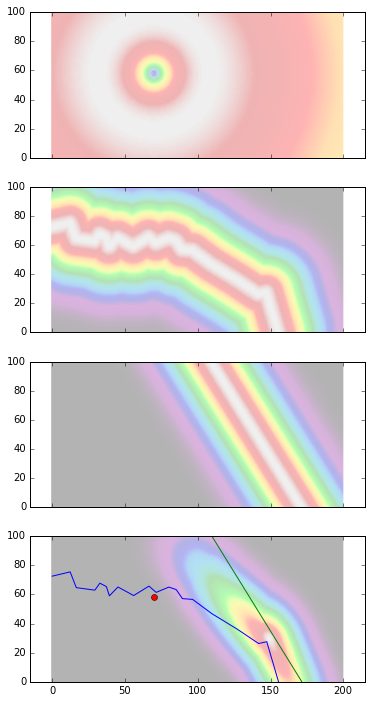

In [14]:
fig, ax = subplots(4, 1, sharex=True, sharey=True, figsize=(6, 12))
colors = 'spectral'
ax[0].imshow(d_gate, cmap=colors, alpha=0.3);
ax[1].imshow(d_spree, cmap=colors, alpha=0.3);
ax[2].imshow(d_path, cmap=colors, alpha=0.3);
ax[3].imshow(heatmap, cmap=colors, alpha=0.3);
ax[3].plot(spree_xy[:,0]*10, spree_xy[:,1]*10);
ax[3].plot(np.array([bgate_x])*10, np.array([bgate_y])*10, 'ro-');
ax[3].plot(sat_path[:,0]*10, sat_path[:,1]*10, 'go-');
ax[3].set_xlim(0, 200);
ax[3].set_ylim(0, 100);

From the topmost image wee see that the correct location is definitely not very close to the brandenburg gate, but it could be anywhere else, most likely on a circle ~4km away from the gate.

On the next image we see where the correct location could be in realation to the river. We see that the probability peaks along the course of the river (white color) and it gradually drops off, such that the correct location being at the top right corner or the bottom left corner is almost impossible.

The third image is similar to the second one. Here the probability peaks along the path of the sattelite, and we can see that most points on the left side of the image seem impossible to be the correct location.

Finally, in the last image, we combine our evidence and see that the location we are looking for is likely in the bottom right part of the image, but quite a large area is still plausible - the correct location won't be so easy to find :) but at least we eliminated about two thirds of the map. In the last image we also did an overlay of the landmarks from the map

Looking at what the heatmap suggests, it seems to make sense that the location is most likely in the area where the river and the sattelite path are closest together.

If we want the exact coordinates of the most likely location, we just have to find the maximum (x, y):

In [15]:
max_j, max_i = np.unravel_index(np.argmax(heatmap), heatmap.shape)
xs[max_i], ys[max_j]

(14.974874371859297, 3.0303030303030303)

and convert it back to coordinates

In [16]:
to_latlon(xs[max_i], ys[max_j])

(52.491231817174373, 13.494887210811308)

However, this point by itself is not very useful. If we were to go to this location it would be quite unlikely to find somthing right away and probably we would have to search a large area. We could, for instance, overlay our final heatmap on a real map to guide our search. But I think that in practice the heatmap would have a few shortcomings if a human used it to guide his search:

- it is not clear how the human would interpret it, and some people would interpret it differently from others
- i suspect that people would focus too much on the peak probability area and neglect the surroundings
- the heatmap does not provide a systematic way of searching so we would have to rely on the people who do the search to be thorough
- someone might be demotivated by seeing what a big area he has to cover

In my opinion it is more practical to just sample points from the location probability distribution and send the search team to the sampled locations. If nothing was found on the first try we would continue the sampling, and perhaps decrease the probability density around the sampled point where nothing was found such as to make it less likely to search there again.

So how do we sample from our heatmap? One easy way is to use rejection sampling (implemented below). Rejection sampling just picks a random x and y and then it draws a random number between 0 and the maximum probability. If the random number is hifgher than the pdf evaluated at (x,y) then we raject the point, otherwise we return it as a sampled location.

In [17]:
def sampler(heatmap, xs, ys, n_vals):
    mx = np.max(heatmap)
    n_rows, n_cols = heatmap.shape
    i_vals, j_vals = range(n_rows), range(n_cols)
    n_sampled = 0
    while n_sampled < n_vals:
        i, j = random.choice(i_vals), random.choice(j_vals)
        pval =  heatmap[i, j]
        rnd = random.random()*mx
        if rnd > pval:
            continue
        yield (xs[j], ys[i])
        n_sampled += 1

In [21]:
sample_points = np.array(list(sampler(heatmap, xs, ys, 40)))

Like this we could sample a number of locations, draw them on the map, and send our search team to the samled locations. If nothing is found we just keep on sampling. This way of searching would be easier to implement because the people doin the search would have very simple to follow instructions: go to these coordinates, look around, report back, repeat.

In [22]:
from IPython.display import Image

img_url = 'http://maps.google.com/maps/api/staticmap?size=512x512&zoom=11&maptype=terrain'
img_url += '&center=%s,%s' % to_latlon(xs[max_i], ys[max_j])
img_url += '&markers=%s,%s' % to_latlon(xs[max_i], ys[max_j])
for point in sample_points:
    img_url += '&markers=size:tiny|%s,%s' % to_latlon(*point)
Image(url=img_url)

the map shows an example of 40 locations sampled from our probability distribution. the largest marker corresponds the peak location

#### Possible improvements by using priors

We know that we are searching for a person (candidate) that is at some unknown location. So far we have assumed that a priori this location is equaly likely anywhere. But we know that people tend to crowd together in some areas rather than others. We could find out which areas are more crowded from a dataset like foursquare for instance, but even if we don't have easy access to such a dataset we could ask the search team to use common sense that somebody is unlikely to be located in the middle of a lake, on the rail tracks, in the forest etc.